#Custom Apriltag image classifier
Author: Sania Zahan Date: 17/11/2025

#Organize Your Dataset:
Create a main directory for your dataset. Inside this main directory, create subdirectories, where each subdirectory represents a class, and contains the images belonging to that class.

Apriltag images: https://github.com/AprilRobotics/apriltag-imgs

Tags and corresponding labels:

tag16h5 -> Left; tag25h9 -> Right;

tag36h11 -> Forward; tagCircle21h7 -> Backward

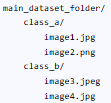

#Download and unzip data
Dataset link: https://github.com/saniazahan/AI-Python/blob/main/Dataset/apriltag_dataset.zip

In [1]:
!unzip apriltag_dataset.zip

Archive:  apriltag_dataset.zip
   creating: apriltag_dataset_v2/
   creating: apriltag_dataset_v2/right/
   creating: apriltag_dataset_v2/backward/
   creating: apriltag_dataset_v2/left/
   creating: apriltag_dataset_v2/stop/
   creating: apriltag_dataset_v2/flashrgb/
   creating: apriltag_dataset_v2/display/
   creating: apriltag_dataset_v2/flashled/
   creating: apriltag_dataset_v2/forward/
   creating: apriltag_dataset_v2/playsound/
  inflating: apriltag_dataset_v2/right/tag36_11_00558.png  
  inflating: apriltag_dataset_v2/right/tag36_11_00564.png  
  inflating: apriltag_dataset_v2/right/tag36_11_00570.png  
  inflating: apriltag_dataset_v2/right/tag36_11_00571.png  
  inflating: apriltag_dataset_v2/right/tag36_11_00565.png  
  inflating: apriltag_dataset_v2/right/tag36_11_00559.png  
  inflating: apriltag_dataset_v2/right/tag36_11_00573.png  
  inflating: apriltag_dataset_v2/right/tag36_11_00567.png  
  inflating: apriltag_dataset_v2/right/tag36_11_00566.png  
  inflating: aprilta

#Import necessary libraries

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16

#Load the Dataset with image_dataset_from_directory:

Keras's image_dataset_from_directory utility is designed for this purpose.

In [6]:
# Define parameters for loading the dataset
IMG_HEIGHT = 224    # VGG16 default input size
IMG_WIDTH  = 224
BATCH_SIZE = 32

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    'apriltag_dataset_v2', # Path to your main dataset folder
    labels='inferred',
    label_mode='int', # 'int' for integer-encoded labels (0, 1, 2...), 'binary' for 0/1, 'categorical' for one-hot
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2, # Optional: split a portion for validation
    subset='training',
    seed=123 # For reproducible split
)

# Load the validation data (if validation_split was used)
val_ds = tf.keras.utils.image_dataset_from_directory(
    'apriltag_dataset_v2',
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    validation_split=0.2,
    subset='validation',
    seed=123
)

# Get class names
class_names = train_ds.class_names
print(f"Class names: {class_names}")

Found 690 files belonging to 9 classes.
Using 552 files for training.
Found 690 files belonging to 9 classes.
Using 138 files for validation.
Class names: ['backward', 'display', 'flashled', 'flashrgb', 'forward', 'left', 'playsound', 'right', 'stop']


#Prepare the Data for Training:
Optimize performance by prefetching and caching.

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Build and Train Your Model:
Define a Convolutional Neural Network (CNN) and train it.

Imagine a Conv2D layer as the model searching an image for specific clues.

It analyses a small area (the 'kernel') to scan over the image, looking for patterns like edges or shapes.

When it finds a pattern, it marks it down. This process creates a new, simplified image that highlights where those patterns were found.

In [7]:
num_classes = len(class_names)

# Load VGG16 without the top classifier
vgg_base = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Freeze convolutional layers (recommended for transfer learning)
vgg_base.trainable = False

model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Pretrained convolutional feature extractor
    vgg_base,

    layers.Flatten(),                          # flatten the feature maps
    layers.Dense(128, activation='relu'),      # similar to your custom model
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

# Model.compile is like giving the model a trainer, a way to measure its mistakes, and a way for us to see how well its doing.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # from_logits=False if using softmax
              metrics=['accuracy'])
# Softmax if the raw scores of a tag prediction were:
# Left: 2.5
# Right: 1.0
# Forward: 3.0
# Backward: 0.5

# Softmax would convert them into something like:
# Left: 20%
# Right: 5%
# Forward: 70%
# Backward: 5%

model.summary()

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,927,241 (68.39 MB)

 Trainable params: 3,212,553 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,927,241 (68.39 MB)

 Trainable params: 3,212,553 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 372s 21s/step - accuracy: 0.1658 - loss: 3.3375 - val_accuracy: 0.4493 - val_loss: 1.6740
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 369s 21s/step - accuracy: 0.2468 - loss: 2.0231 - val_accuracy: 0.8478 - val_loss: 1.3383
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 359s 20s/step - accuracy: 0.3289 - loss: 1.8719 - val_accuracy: 0.4420 - val_loss: 1.8199
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 384s 20s/step - accuracy: 0.2995 - loss: 1.8138 - val_accuracy: 0.4565 - val_loss: 1.8396
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 369s 21s/step - accuracy: 0.3196 - loss: 1.8075 - val_accuracy: 0.3406 - val_loss: 1.7223
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 382s 21s/step - accuracy: 0.4081 - loss: 1.6752 - val_accuracy: 0.4638 - val_loss: 1.3456
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 368s 21s/step - accuracy: 0.4207 - loss: 1.6005 - val_accuracy: 0.6667 - val_loss: 1.1725
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 369s 21s/step - accuracy: 0.5370 - loss: 1.4581 - val_accuracy: 0.

In [8]:
# === Save the trained Keras model ===

model.save("apriltag_model.keras")   # Modern recommended format

# Optional: Save also to H5 if you want broader compatibility
# model.save("apriltag_model.h5")

print("Model saved successfully as apriltag_model.keras!")

Model saved successfully as apriltag_model.keras!


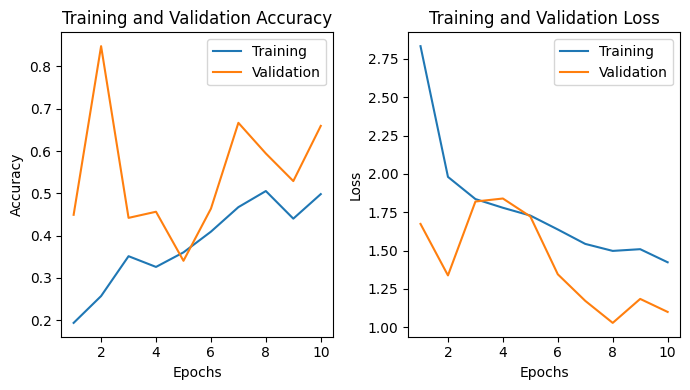

In [9]:
# Get the history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate and Predict:
Evaluate the model's performance and make predictions on new images.

In [21]:
# Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print(f"Validation accuracy: {accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 77s 15s/step - accuracy: 0.5879 - loss: 1.2431
Validation accuracy: 0.6594203114509583


In [20]:
import os
import random
all_images = []
for root, dirs, files in os.walk('apriltag_dataset_v2'):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
            all_images.append(os.path.join(root, file))
# Randomly pick 10
selected = random.sample(all_images, 10)
for image_path in selected:
  actual_label = image_path.split('/')[1]
  img = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  print(f"This image most likely belongs to {class_names[tf.argmax(score)]} with a {100 * tf.reduce_max(score):.2f}% confidence. Acutal label is {actual_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
This image most likely belongs to flashrgb with a 12.03% confidence. Acutal label is flashrgb
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
This image most likely belongs to left with a 13.85% confidence. Acutal label is forward
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
This image most likely belongs to left with a 16.27% confidence. Acutal label is left
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
This image most likely belongs to forward with a 12.29% confidence. Acutal label is forward
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
This image most likely belongs to forward with a 12.87% confidence. Acutal label is flashled
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
This image most likely belongs to backward with a 25.35% confidence. Acutal label is backward
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
This image most likely belongs to forward with a 13.04% confidence. Acutal label is display
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
This image most likely belongs to left with a 13